In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model
import umap


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)
from medpy.filter.smoothing import anisotropic_diffusion

2023-02-08 22:40:01.937542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-08 22:40:01.937619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ModuleNotFoundError: No module named 'medpy'

In [7]:
order = 1
num_classes = 20
splines = get_model("splines_cont",it_lim=3,image_size=image_size,num_classes = 20,order=order)
splines.load_weights(f"./checkpoints/splinescont2_{typ}_20")
decreasing = get_model("decreasing_linear",it_lim=3,image_size=image_size,num_classes = num_classes)
decreasing.load_weights(f"../decreasing/checkpoints/declinear_{typ}_{num_classes}")
taylor = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = 50)
taylor.load_weights(f"../decreasing/checkpoints/dectaylor_{typ}_50")

model = [splines,decreasing,taylor]
#model = [splines,decreasing]

w = np.linspace(10,55,10)
#psnr_nn_1,psnr_nn_s_1 = [[],[],[]],[[],[],[]]
#ssim_nn_1,ssim_nn_s_1 = [[],[],[]],[[],[],[]]

psnr_nn_1,psnr_nn_s_1 = [[] for i in range(len(model))],[[] for i in range(len(model))]
ssim_nn_1,ssim_nn_s_1 = [[] for i in range(len(model))],[[] for i in range(len(model))]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

psnr_or_1,psnr_or_s_1 = [],[]
ssim_or_1,ssim_or_s_1 = [],[]


for i,m in tqdm(enumerate(w)):
    gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=250)
    
    for en in range(len(model)):
        psnr_nn_1[en].append([])
        psnr_nn_s_1[en].append([])
        ssim_nn_1[en].append([])
        ssim_nn_s_1[en].append([])
        
    psnr_pm_1.append([])
    psnr_pm_s_1.append([])
    ssim_pm_1.append([])
    ssim_pm_s_1.append([])
    psnr_or_1.append([])
    psnr_or_s_1.append([])
    ssim_or_1.append([])
    ssim_or_s_1.append([])
    
    for it in range(1):
        ims = next(gen_batch_val.as_numpy_iterator())

        for en in range(len(model)):
            res = model[en](ims[0])
            psnr = tf.image.psnr(res,ims[1],1).numpy()
            ssim = tf.image.ssim(res,ims[1],1).numpy()
            psnr_nn_1[en][-1].append(np.copy(psnr))
            psnr_nn_s_1[en][-1].append(np.copy(psnr))
            ssim_nn_1[en][-1].append(np.copy(ssim))
            ssim_nn_s_1[en][-1].append(np.copy(ssim))

        pm = np.array([anisodiff(im,niter = 3,lambd=50) for im in ims[0]['input']])
        pm = np.asarray(pm,dtype='float32')
        psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_pm_1[-1].append(np.copy(psnr))
        psnr_pm_s_1[-1].append(np.copy(psnr))
        ssim_pm_1[-1].append(np.copy(ssim))
        ssim_pm_s_1[-1].append(np.copy(ssim))

        psnr = tf.image.psnr(ims[0]['input'],ims[1],1).numpy()
        ssim = tf.image.ssim(ims[0]['input'],ims[1],1).numpy()
        psnr_or_1[-1].append(np.copy(psnr))
        psnr_or_s_1[-1].append(np.copy(psnr))
        ssim_or_1[-1].append(np.copy(ssim))
        ssim_or_s_1[-1].append(np.copy(ssim))
     
    for en in range(len(model)):
        psnr_nn_1[en][-1] = np.concatenate(psnr_nn_1[en][-1])
        psnr_nn_s_1[en][-1] = np.concatenate(psnr_nn_s_1[en][-1])
        ssim_nn_1[en][-1] = np.concatenate(ssim_nn_1[en][-1])
        ssim_nn_s_1[en][-1] = np.concatenate(ssim_nn_s_1[en][-1])
    
    psnr_pm_1[-1] = np.concatenate(psnr_pm_1[-1])
    psnr_pm_s_1[-1] = np.concatenate(psnr_pm_s_1[-1])
    ssim_pm_1[-1] = np.concatenate(ssim_pm_1[-1])
    ssim_pm_s_1[-1] = np.concatenate(ssim_pm_s_1[-1])
    
    psnr_or_1[-1] = np.concatenate(psnr_or_1[-1])
    psnr_or_s_1[-1] = np.concatenate(psnr_or_s_1[-1])
    ssim_or_1[-1] = np.concatenate(ssim_or_1[-1])
    ssim_or_s_1[-1] = np.concatenate(ssim_or_s_1[-1])
    
    
psnr_pm_1 = np.mean(psnr_pm_1,axis=-1)
psnr_pm_s_1 = np.std(psnr_pm_s_1,axis=-1)
ssim_pm_1 = np.mean(ssim_pm_1,axis=-1)
ssim_pm_s_1 = np.std(ssim_pm_s_1,axis=-1)
psnr_or_1 = np.mean(psnr_or_1,axis=-1)
psnr_or_s_1 = np.std(psnr_or_s_1,axis=-1)
ssim_or_1 = np.mean(ssim_or_1,axis=-1)
ssim_or_s_1 = np.std(ssim_or_s_1,axis=-1)

10it [01:21,  8.17s/it]


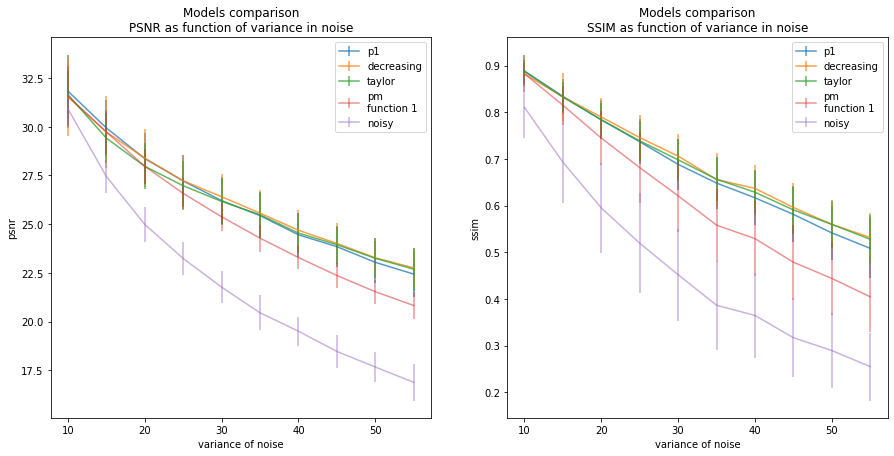

In [8]:
plt.figure(figsize=(15,7))
plt.subplot(121)

names = ['p1','decreasing','taylor']

for i in range(len(model)):
    plt.errorbar(w,np.mean(psnr_nn_1,axis=-1)[i],np.std(psnr_nn_1,axis=-1)[i],label=names[i],alpha=0.75)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_or_1,psnr_or_s_1,label='noisy',alpha=0.5)

plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('Models comparison\nPSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
for i in range(len(model)):
    plt.errorbar(w,np.mean(ssim_nn_1,axis=-1)[i],np.std(ssim_nn_1,axis=-1)[i],label=names[i],alpha=0.75)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_or_1,ssim_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('Models comparison\nSSIM as function of variance in noise')
plt.legend()
plt.show()

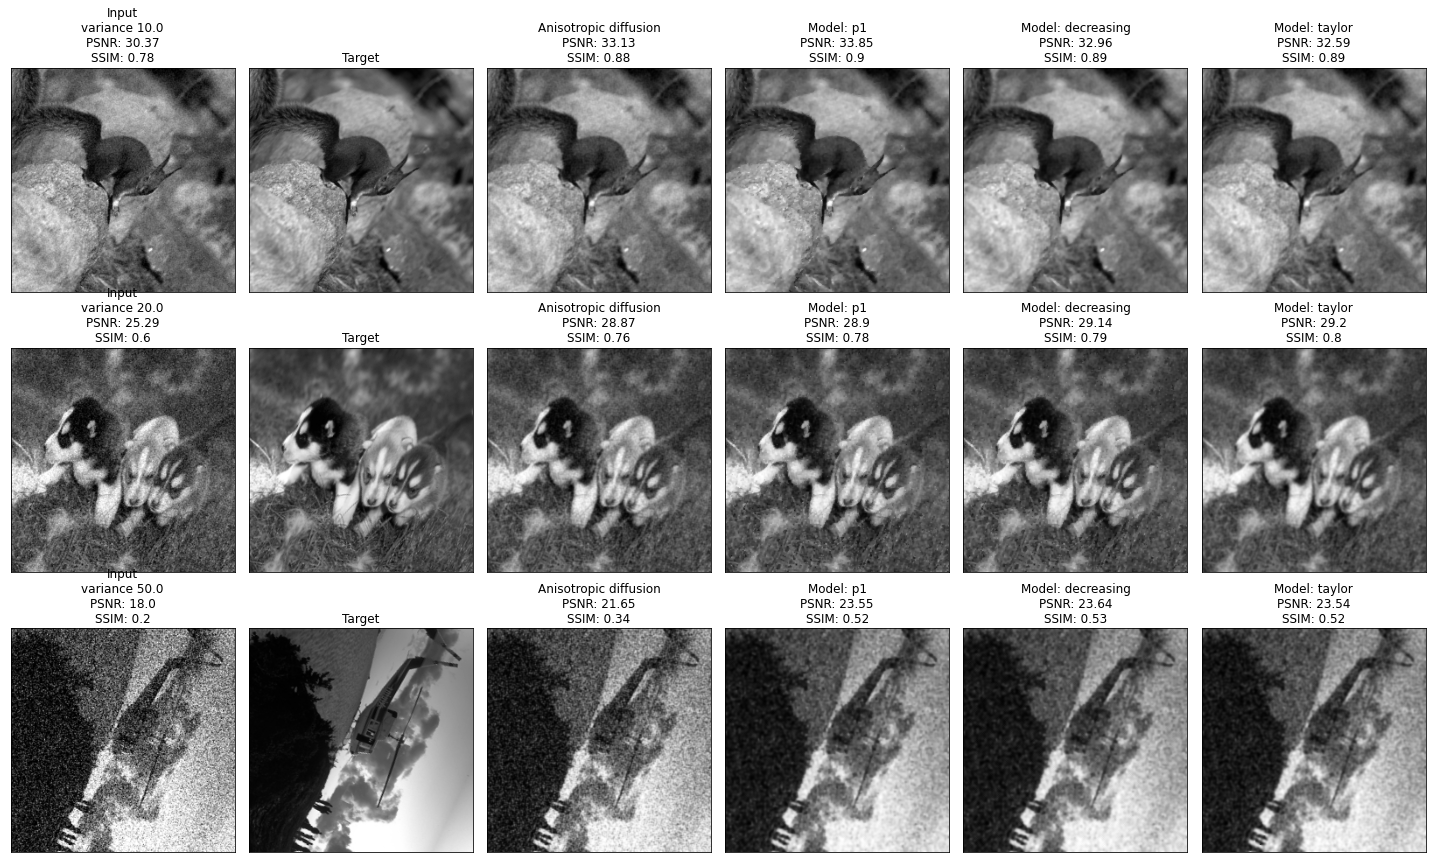

In [9]:
w = [10,20,50]
names = ['p1','decreasing','taylor']
#names = ['p1','decreasing']
fig,axs = plt.subplots(ncols = 6,nrows = int(np.ceil(len(w))),figsize=(20,4*len(w)))

for i,m in enumerate(w):

    
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=2)
    ims = next(gen_batch_val.as_numpy_iterator())
    _ = np.random.choice(len(ims[0]))


    psnr_0 = tf.image.psnr(ims[0]['input'][_],ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(ims[0]['input'][_],ims[1][_],1).numpy()
    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    
    
    axs[i,0].imshow(ims[0]['input'][_],cmap='gray')
    axs[i,0].set_title(f'Input\nvariance {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(ims[1][_],cmap='gray')
    axs[i,1].set_title('Target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    
    pm = anisodiff(ims[0]['input'][_],niter=3,lambd=50)
    pm = np.asarray(pm,dtype='float32')
    psnr_0 = tf.image.psnr(pm,ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(pm,ims[1][_],1).numpy()
    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    axs[i,2].imshow(pm,cmap='gray')
    axs[i,2].set_title(f'Anisotropic diffusion\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    
    for mod in range(len(model)):
        pm = model[mod](ims[0])[_]
        pm = np.asarray(pm,dtype='float32')
        psnr_0 = tf.image.psnr(pm,ims[1][_],1).numpy()
        ssim_0 = tf.image.ssim(pm,ims[1][_],1).numpy()
        psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
        axs[i,3+mod].imshow(np.copy(pm),cmap='gray')
        axs[i,3+mod].set_title(f'Model: {names[mod]}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
        axs[i,3+mod].set_xticks([])
        axs[i,3+mod].set_xticklabels([])
        axs[i,3+mod].set_yticks([])
        axs[i,3+mod].set_yticklabels([])
    
    
plt.tight_layout()
plt.show()

# Trajectory

In [25]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=20,CROP1=CROP,BATCH_SIZE=50)
ims = next(gen_batch_val.as_numpy_iterator())

In [20]:
num_classes = 50

model = get_model("decreasing_taylor",it_lim=3,image_size=image_size,num_classes = num_classes)
model.load_weights(f"../decreasing/checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

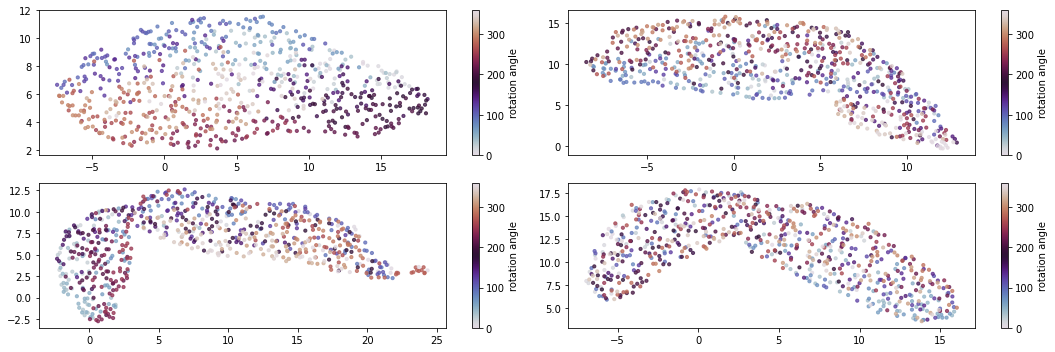

In [7]:
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,5))
norm = mpl.colors.Normalize(vmin=0, vmax=360)

for it in range(4):

    im = ims[0]['input'][np.random.choice(len(ims[0]['input']))]
    ch,cw = im.shape[:2]
    traj = []


    for i in np.linspace(0,360,720):
        rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),i,1)
        r_im = cv2.warpAffine(im,rotation_matrix,(ch,cw),cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT)
        traj.append(np.expand_dims(np.copy(r_im),axis=-1))

    traj1 = np.array(traj)[:360]
    inp = {'input':traj1,'input_emb':np.expand_dims(50*np.ones(len(traj1)),axis=-1)}
    cte1 = np.squeeze(get_cte(inp))
    linear1 = np.squeeze(get_linear(inp))
    quad1 = np.squeeze(get_quad(inp))
    
    traj2 = np.array(traj)[360:]
    inp = {'input':traj2,'input_emb':np.expand_dims(50*np.ones(len(traj2)),axis=-1)}
    cte2 = np.squeeze(get_cte(inp))
    linear2 = np.squeeze(get_linear(inp))
    quad2 = np.squeeze(get_quad(inp))
    
    cte = np.concatenate((cte1,cte2))
    linear = np.concatenate((linear1,linear2))
    quad = np.concatenate((quad1,quad2))
    

    X = np.concatenate([np.expand_dims(cte,axis=-1),np.expand_dims(linear,axis=-1),quad],axis=-1)
    reducer = umap.UMAP(n_neighbors=50,min_dist=0.99)

    m = np.expand_dims(np.mean(X,axis=1),axis=-1)
    s = np.expand_dims(np.std(X,axis=1),axis=-1)
    X1 = (X-m)/s
    #X1 = (X-np.mean(X))/np.std(X)
    
    colors = cm.twilight(np.linspace(0,1,len(X)))
    embedding = reducer.fit_transform(X1)
    axs[it//2,it%2].scatter(embedding[:, 0],embedding[:, 1],color=colors,alpha=0.75,s=10)
    
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=ListedColormap(colors)),ax=axs[it//2,it%2],label='rotation angle')

plt.tight_layout()
plt.show()

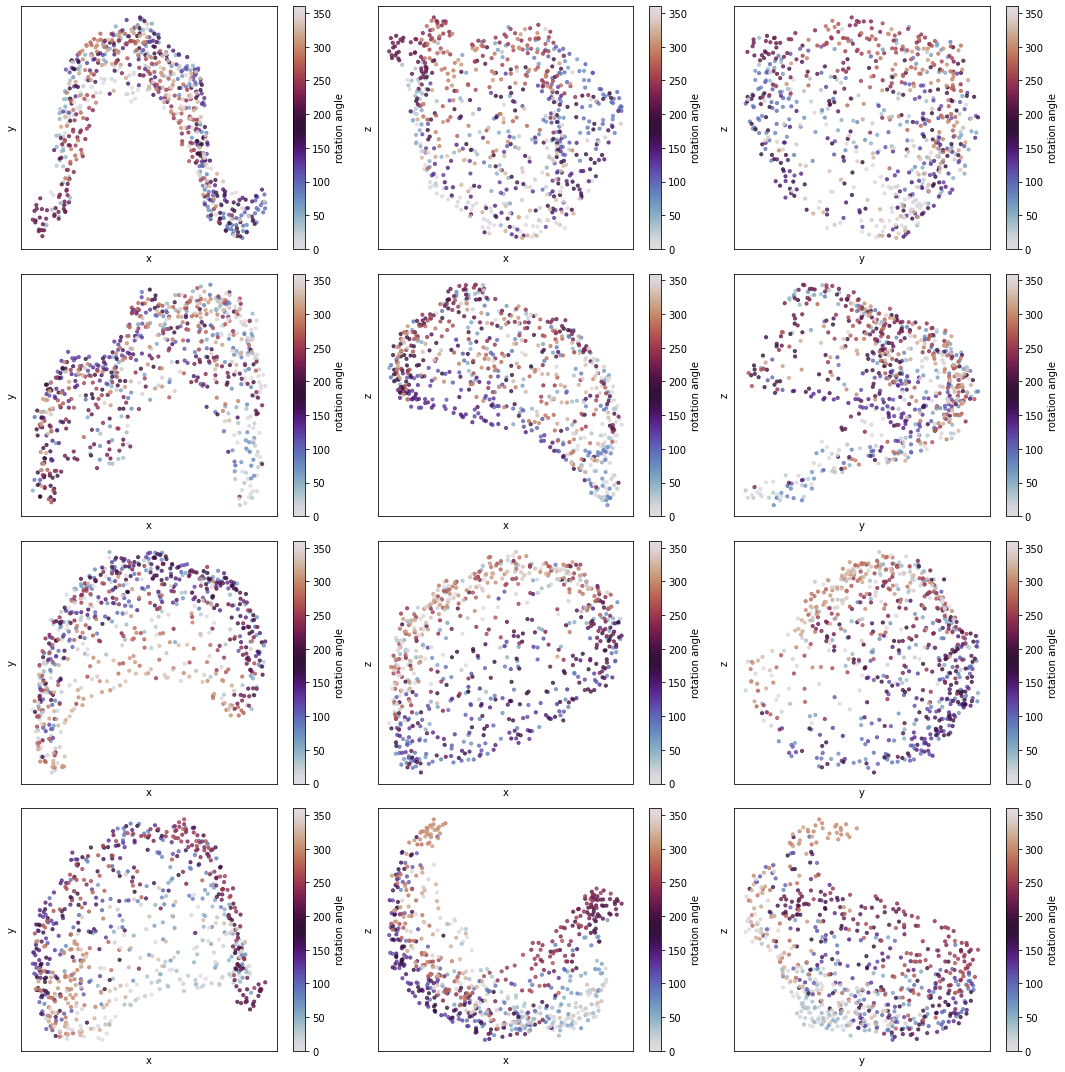

In [27]:
fig,axs = plt.subplots(ncols=3,nrows=4,figsize=(15,15))
norm = mpl.colors.Normalize(vmin=0, vmax=360)

for it in range(4):

    im = ims[0]['input'][np.random.choice(len(ims[0]['input']))]
    ch,cw = im.shape[:2]
    traj = []


    for i in np.linspace(0,360,720):
        rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),i,1)
        r_im = cv2.warpAffine(im,rotation_matrix,(ch,cw),cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT)
        traj.append(np.expand_dims(np.copy(r_im),axis=-1))

    traj1 = np.array(traj)[:360]
    inp = {'input':traj1,'input_emb':np.expand_dims(50*np.ones(len(traj1)),axis=-1)}
    cte1 = np.squeeze(get_cte(inp))
    linear1 = np.squeeze(get_linear(inp))
    quad1 = np.squeeze(get_quad(inp))
    
    traj2 = np.array(traj)[360:]
    inp = {'input':traj2,'input_emb':np.expand_dims(50*np.ones(len(traj2)),axis=-1)}
    cte2 = np.squeeze(get_cte(inp))
    linear2 = np.squeeze(get_linear(inp))
    quad2 = np.squeeze(get_quad(inp))
    
    cte = np.concatenate((cte1,cte2))
    linear = np.concatenate((linear1,linear2))
    quad = np.concatenate((quad1,quad2))
    

    X = np.concatenate([np.expand_dims(cte,axis=-1),np.expand_dims(linear,axis=-1),quad],axis=-1)
    reducer = umap.UMAP(n_neighbors=50,min_dist=0.99,n_components=3)

    m = np.expand_dims(np.mean(X,axis=1),axis=-1)
    s = np.expand_dims(np.std(X,axis=1),axis=-1)
    X1 = (X-m)/s
    #X1 = (X-np.mean(X))/np.std(X)
    
    colors = cm.twilight(np.linspace(0,1,len(X)))
    embedding = reducer.fit_transform(X1)
    axs[it,0].scatter(embedding[:, 0],embedding[:, 1],color=colors,alpha=0.75,s=10)
    axs[it,0].set_xlabel('x')
    axs[it,0].set_ylabel('y')
    axs[it,1].scatter(embedding[:, 0],embedding[:, 2],color=colors,alpha=0.75,s=10)
    axs[it,1].set_xlabel('x')
    axs[it,1].set_ylabel('z')
    axs[it,2].scatter(embedding[:, 1],embedding[:, 2],color=colors,alpha=0.75,s=10)
    axs[it,2].set_xlabel('y')
    axs[it,2].set_ylabel('z')
    
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=ListedColormap(colors)),ax=axs[it,0],label='rotation angle')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=ListedColormap(colors)),ax=axs[it,1],label='rotation angle')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=ListedColormap(colors)),ax=axs[it,2],label='rotation angle')
    
    axs[it,0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    axs[it,1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    axs[it,2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

plt.tight_layout()
plt.show()

# Debugging

In [3]:
gen_batch_train,gen_batch_val = get_generators(typ,20,60,CROP1=CROP,BATCH_SIZE=250)
xs,ys = next(gen_batch_val.as_numpy_iterator())

2023-02-08 21:44:21.691533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 21:44:21.691849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 21:44:21.720139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 21:44:21.720380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 21:44:21.720566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [4]:
lambd = 50
gamma = 0.1
n_iter = 5

In [7]:
def get_models(input_shape):

    inputs = tf.keras.Input(shape=input_shape,name='input')
    
    deltaS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    deltaE = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    NS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    EW = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    gS = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)
    gE = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)
    
    outputs = inputs

    for ii in np.arange(1,n_iter):

        difS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(outputs)
        difE = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(outputs)
        zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
        zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
        deltaS = tf.keras.layers.Concatenate(axis=1)([difS,zeros_x])
        deltaE = tf.keras.layers.Concatenate(axis=2)([difE,zeros_y])

        gS = tf.keras.layers.Lambda(lambda z: tf.exp(-tf.pow(z/lambd,2)))(deltaS)
        gE = tf.keras.layers.Lambda(lambda z: tf.exp(-tf.pow(z/lambd,2)))(deltaE)

        E = tf.keras.layers.multiply((gE,deltaE))
        S = tf.keras.layers.multiply((gS,deltaS))

        NS = S
        EW = E
        NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
        EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
        NS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(NS)
        EW = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(EW)

        mult = gamma*tf.ones_like(NS)
        adding = tf.keras.layers.add([NS,EW])
        adding = tf.keras.layers.multiply((mult,adding))

        outputs = tf.keras.layers.Lambda(lambda z:tf.identity(z))(outputs)
        outputs = tf.keras.layers.add([outputs,adding])
            
    return tf.keras.models.Model(inputs, outputs)

model = get_models(image_size + (1,))

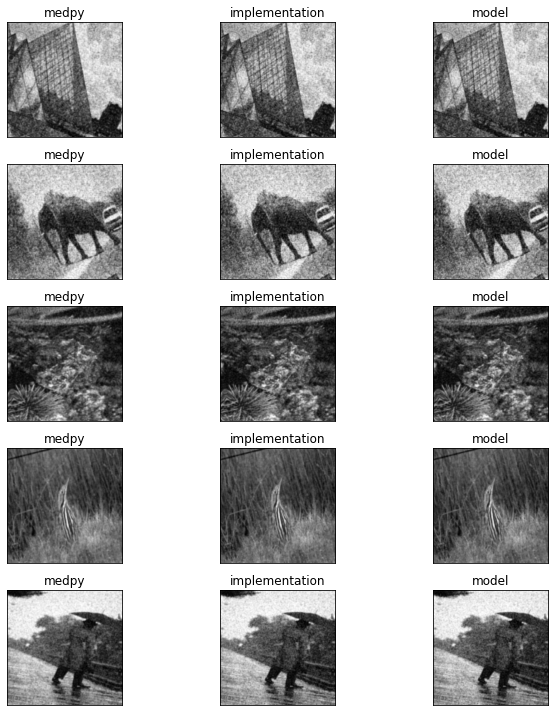

In [72]:
mod = model(xs)

fig,axs = plt.subplots(ncols=3,nrows=5,figsize=(10,10))

for it in range(5):
    _ = np.random.choice(len(xs['input']))

    diff_out = anisotropic_diffusion(np.squeeze(xs['input'][_]), niter=n_iter, kappa=lambd, option=1)
    diff_out = np.asarray(diff_out,dtype='float32')
    an = anisodiff(np.squeeze(xs['input'][_]),niter = n_iter,lambd=lambd)
    an = np.asarray(an,dtype='float32')

    #print(tf.image.psnr(np.expand_dims(diff_out,axis=-1),np.expand_dims(an,axis=-1),1))
    #print(tf.image.psnr(np.expand_dims(diff_out,axis=-1),mod[_],1))


    axs[it][0].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
    axs[it][0].imshow(diff_out,cmap='gray')
    axs[it][0].set_title('medpy')
    
    axs[it][1].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
    axs[it][1].imshow(an,cmap='gray')
    axs[it][1].set_title('implementation')
    
    axs[it][2].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
    axs[it][2].imshow(np.squeeze(mod[_]),cmap='gray')
    axs[it][2].set_title('model')
    
plt.tight_layout()
plt.show()

/home/joel/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['input_emb'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/joel/anaconda3/lib/python3.9/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/joel/anaconda3/lib/python3.9/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different

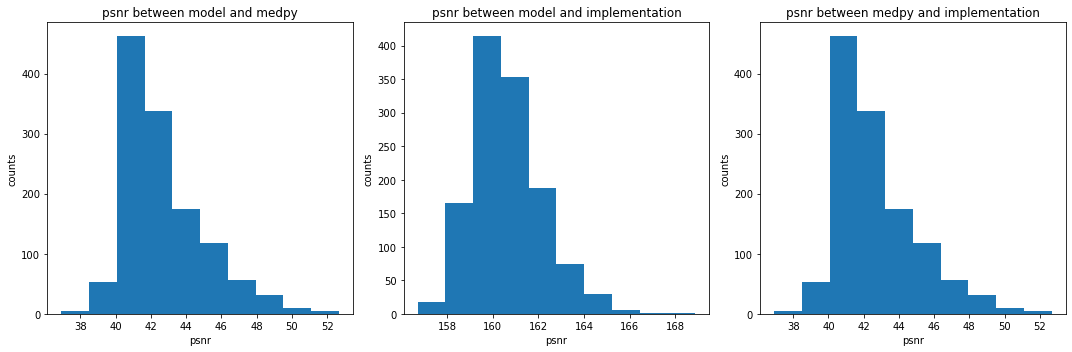

In [96]:
mod,medpy,imp = [],[],[]

for i in range(5):
    xs,ys = next(gen_batch_val.as_numpy_iterator())
    m = model(xs)
    diff_out = [anisotropic_diffusion(np.squeeze(_), niter=n_iter, kappa=lambd, option=1) for _ in xs['input']]
    an = [anisodiff(np.squeeze(_),niter = n_iter,lambd=lambd) for _ in xs['input']]
    
    mod.append(np.copy(m))
    medpy.append(np.copy(np.asarray(diff_out,dtype='float32')))
    imp.append(np.copy(np.asarray(an,dtype='float32')))
    
mod = np.squeeze(np.concatenate(mod))
medpy = np.squeeze(np.concatenate(medpy))
imp = np.squeeze(np.concatenate(imp))

mod = np.expand_dims(mod,axis=-1)
medpy = np.expand_dims(medpy,axis=-1)
imp = np.expand_dims(imp,axis=-1)

mm = tf.image.psnr(mod,medpy,1).numpy()
mi = tf.image.psnr(mod,imp,1).numpy()
mei = tf.image.psnr(imp,medpy,1).numpy()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(mm)
plt.title('psnr between model and medpy')
plt.xlabel('psnr')
plt.ylabel('counts')
plt.subplot(132)
plt.hist(mi)
plt.title('psnr between model and implementation')
plt.xlabel('psnr')
plt.ylabel('counts')
plt.subplot(133)
plt.hist(mei)
plt.title('psnr between medpy and implementation')
plt.xlabel('psnr')
plt.ylabel('counts')

plt.tight_layout()
plt.show()